In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import sys
sys.path.append("..")

import jax
import jax.numpy as jnp
from jax import vmap, jit

import time
import matplotlib.pyplot as plt


In [2]:
from evosax.strategies.cma_es import init_strategy, ask, tell, check_termination
from evosax.utils import init_logger, update_logger
from evosax.utils import flat_to_network, get_total_params, get_network_shapes
from examples.ffw_pendulum import ffw_policy, init_policy_mlp

In [3]:
import gymnax
from gymnax.rollouts import DeterministicRollouts

rng, reset, step, env_params = gymnax.make("Pendulum-v0", seed_id=0)

# Episode Rollout from Random Init Policy

In [4]:
parallel_episodes = 10
rng, rng_net, rng_episode = jax.random.split(rng, 3)
rng_batch = jax.random.split(rng, parallel_episodes)

# Rollout single episode with lax.scan
rng, rng_input = jax.random.split(rng)
policy_params = init_policy_mlp(rng_input, [3, 16, 1], scale=1e-2)

collector = DeterministicRollouts(ffw_policy, step, reset, env_params)
collector.init_collector()
trace, reward = collector.episode_rollout(rng_episode, policy_params)
traces, rewards = collector.batch_rollout(rng_batch, policy_params)
print(rewards.shape)

(10, 200)


In [5]:
total_no_params = get_total_params(policy_params)
network_shapes = get_network_shapes(policy_params)
print(total_no_params, network_shapes)

81 FrozenDict({
    layer_in: {
        W1: (16, 3),
        b1: (16,),
    },
    layer_out: {
        W2: (1, 16),
        b2: (1,),
    },
})


In [6]:
# Wrap reshaping of param vector and rollout into single fct. to vmap
def reshape_and_eval(rng, x, network_shapes):
    """ Perform both parameter reshaping and evaluation in one go. """
    net_params = flat_to_network(x, network_shapes)
    traces, returns = collector.batch_rollout(rng, net_params)
    return - returns.mean(axis=0).sum()

In [7]:
# Rollout 10 for batch of 2 weight initialisations
generation_params = jnp.zeros((2, total_no_params))
generation_rollout = vmap(reshape_and_eval, in_axes=(None, 0, None))
results = generation_rollout(rng_batch, generation_params, network_shapes)
results

DeviceArray([1151.6909, 1151.6909], dtype=float32)

# Neuroevolution with CMA-ES

In [8]:
mean_init, sigma_init = jnp.zeros(total_no_params), 1
pop_size, mu = 100, 50
num_evals_per_gen = 20
num_generations = 200

top_k = 5
evo_logger = init_logger(top_k, total_no_params, network_shapes)

params, memory = init_strategy(mean_init, sigma_init,
                               pop_size, mu)

# Run generation loop on Pendulum Task

In [9]:
start_t = time.time()
for g in range(num_generations):
    # Ask ES for next generation params
    rng, rng_ask, rng_eval = jax.random.split(rng, 3)
    x, memory = ask(rng_ask, params, memory)
    
    # Reshape and rollout/eval batch
    rollout_keys = jax.random.split(rng_eval, num_evals_per_gen)
    values = generation_rollout(rollout_keys, x, network_shapes)

    # Update ES, log + check for termination
    memory = tell(x, values, params, memory)
    evo_logger = update_logger(evo_logger, x, values, memory, top_k)
    if (g + 1) % 15 == 0:
        print("# Generations: {} | Fitness: {:.2f} | Cum. Time: {:.2f}".format(
                g+1, evo_logger["top_values"][0],
                time.time()-start_t))
        # jnp.save("gen_" + str(g+1), evo_logger["top_params"])
        if check_termination(values, params, memory):
            break

# Generations: 15 | Fitness: 683.48 | Cum. Time: 10.45
# Generations: 30 | Fitness: 616.36 | Cum. Time: 12.86
# Generations: 45 | Fitness: 459.64 | Cum. Time: 14.60
# Generations: 60 | Fitness: 459.64 | Cum. Time: 16.32
# Generations: 75 | Fitness: 459.64 | Cum. Time: 18.04
# Generations: 90 | Fitness: 459.64 | Cum. Time: 19.79
# Generations: 105 | Fitness: 323.61 | Cum. Time: 21.59
# Generations: 120 | Fitness: 225.53 | Cum. Time: 23.36
# Generations: 135 | Fitness: 152.30 | Cum. Time: 25.20
# Generations: 150 | Fitness: 124.32 | Cum. Time: 27.00
# Generations: 165 | Fitness: 124.32 | Cum. Time: 28.73
# Generations: 180 | Fitness: 114.50 | Cum. Time: 30.58
# Generations: 195 | Fitness: 114.50 | Cum. Time: 32.66


In [10]:
# Save log to .pkl file
from evosax.utils import save_logger, load_logger
save_logger(evo_logger, 'pendulum_log.pkl')
loaded_log = load_logger('pendulum_log.pkl')
# loaded_log["top_values"]

# Visualize log over generations

In [11]:
from evosax.visualize.plot_log import plot_fitness, plot_sigma
import matplotlib.pyplot as plt

(<Figure size 864x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff532c1ca20>)

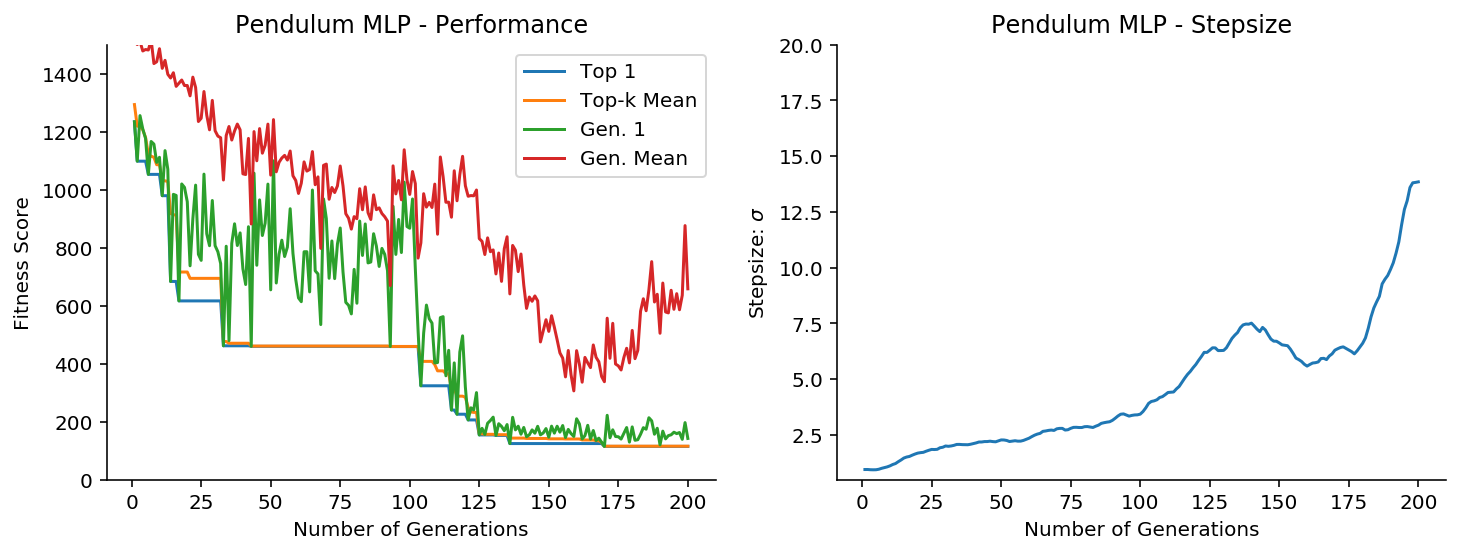

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_fitness(loaded_log, title="Pendulum MLP - Performance", ylims=(0, 1500), fig=fig, ax=axs[0])
plot_sigma(loaded_log, title="Pendulum MLP - Stepsize", ylims=(0.5, 20), fig=fig, ax=axs[1])

In [ ]:
from mle_toolbox.utils import load_log, hyper_log_to_df

In [ ]:
log_path = "/Users/rtl/Dropbox/core-code/mle-toolbox/examples/experiments/meta_log.hdf5" 

In [ ]:
log = load_log(log_path, mean_seeds=True)
log.b_1_eval_4.meta.eval_id.collected

In [ ]:
df_path = "/Users/rtl/Dropbox/core-code/mle-toolbox/examples/experiments/hyper_log.pkl"

In [ ]:
df = hyper_log_to_df(df_path)

In [ ]:
df

In [23]:
import logging
from pprint import pformat
ds = {'hello': 'there'}
print(pformat(ds))

{'hello': 'there'}
